## 1. Setup and download

Import the required libraries

In [2]:
%env PYTHONHASHSEED 3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
!pip install -q pandas

env: PYTHONHASHSEED=3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Setup up PySpark (copied from the labs)

In [3]:
from math import sqrt
import pyspark
import pandas
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
spark = SparkSession.builder.master("local[*]").appName('SparkExample').config(
    "spark.executor.memory", "1g").config("spark.ui.port", "4050"
        ).getOrCreate()
sc = spark.sparkContext

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

Download the relevant files

In [4]:
import urllib.request
# Ingredient pickle
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&confirm=t&id=1YanHYctZUusAcRMac4kjlA-YwIrEk1Ay', "ingr_map.pkl")
# Datasets
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&confirm=t&id=1kCMzn9P82VmuC_nFcP1wOHMZtR4e6qij', "PP_recipes.csv")
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&confirm=t&id=1agAwyHqwhubiisq63IOIGBFFVCi6bdqM', "PP_users.csv")
# urllib.request.urlretrieve('https://drive.google.com/uc?export=download&confirm=t&id=16m3iJexWfP5Nl4uvi2d9tOQo1Jtn_vLT', "RAW_interactions.csv")
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&confirm=t&id=1Vi3CKxSwZ2_7rhqCbARx2PONHNxalYU0', "RAW_recipes.csv")

('RAW_recipes.csv', <http.client.HTTPMessage at 0x7f2190027fd0>)

Luckily, this dataset has already pre-processed our ingredients (`ingr_map.pkl`), so we don't need to worry as much about different names for the same ingredients

In [5]:
from IPython.display import display, HTML
# The ingredient-to-commonName mapping
ingredient_map = spark.createDataFrame(pandas.read_pickle('ingr_map.pkl'))
# The pre-processed recipes & reviews
recipes = spark.read.option('header', 'true').csv("PP_recipes.csv")
user_reviews = spark.read.option('header', 'true').csv("PP_users.csv")
# The raw recipes to test how the pre-processed data is structured
raw_recipes = spark.read.option('header', 'true').csv("RAW_recipes.csv")

In [6]:
# The pre-processed data seems to be designed for machine learning algorithms,
# and contains extra data like name tokens which aren't relevant to us.

recipe_id_and_ingredient_tokens = recipes.drop(#'i', 
                                               'name_tokens', 'steps_tokens', 'calorie_level', 'techniques', 'ingredient_tokens')
ingredient_map = ingredient_map.drop('raw_words', 'len_proc', 'count')
user_reviews = user_reviews.drop('u', 'techniques', 'n_items', 'n_ratings')

### 1.1. Testing our ingredient map
Let's test if we're interpreting the columns correctly

In [7]:
test_recipe = recipe_id_and_ingredient_tokens.take(1)[0]
dbg(test_recipe)  # Row(id='424415', ingredient_ids='[389, 7655, 6270, 1527, 3406]')

# This matches the recipe https://www.food.com/recipe/aromatic-basmati-rice-rice-cooker-424415

test_ingredient_ids = [389, 7655, 6270, 1527, 3406]
print('ingredient_ids:', test_ingredient_ids)
for token in test_ingredient_ids:
  print("token =", token)
  ingredient_map.where(ingredient_map.id == token).show(truncate=False)

# The printed ingredients are: basmati rice, water, salt, cinnamon stick, green cardamom pod.
# This also matches the recipe from the URL
# Therefore, we have the correct recipe.

Row(id='424415', i='23', ingredient_ids='[389, 7655, 6270, 1527, 3406]')
ingredient_ids: [389, 7655, 6270, 1527, 3406]
token = 389
+------------+------------+------------+---+
|raw_ingr    |processed   |replaced    |id |
+------------+------------+------------+---+
|basmati rice|basmati rice|basmati rice|389|
+------------+------------+------------+---+

token = 7655
+--------+---------+--------+----+
|raw_ingr|processed|replaced|id  |
+--------+---------+--------+----+
|water   |water    |water   |7655|
+--------+---------+--------+----+

token = 6270
+-------------------------------+---------+--------+----+
|raw_ingr                       |processed|replaced|id  |
+-------------------------------+---------+--------+----+
|aunt jane's krazy mixed up salt|salt     |salt    |6270|
|low sodium salt                |salt     |salt    |6270|
|salt                           |salt     |salt    |6270|
+-------------------------------+---------+--------+----+

token = 1527
+---------------+----

### 1.2. Testing our reviews

In [8]:
def parse_string_to_list(string: str) -> list:
  return tuple(
      int(float(x)) for x in string[1:-1].split(',')
  )

In [9]:
# Let's make it easy, let's find a recipe with only one review
# Note: This pre-processed data links to the recipe's `i` value, not its ID
reviews_rdd = user_reviews.rdd
reviews_i_to_count = (
    reviews_rdd
      .flatMap(lambda row: [(item, 1) for item in parse_string_to_list(row.items)])
      .reduceByKey(lambda a, b: a+b)
)
print(reviews_i_to_count.takeOrdered(1, lambda kv: kv[1])[0])   # (172222, 1)

# So, let's check out the recipe with an `i` of 172222
recipe_id_and_ingredient_tokens.where(recipe_id_and_ingredient_tokens.i == 172222).show()
# This has an ID of 63965
raw = raw_recipes.where(raw_recipes.id == 63965).select('name')
print(raw.take(1)[0])   # [Row(name='lentil and orzo salad')]

(172222, 1)
+-----+------+--------------------+
|   id|     i|      ingredient_ids|
+-----+------+--------------------+
|63965|172222|[5122, 6272, 5006...|
+-----+------+--------------------+

Row(name='lentil and orzo salad')


This recipe correlates to [this lentil and orzo salad recipe](https://www.food.com/recipe/lentil-and-orzo-salad-63965), which also has one 5-star review

## 2. Determine Review Scores

In [10]:
# Let's calculate the average rating of each recipe

from operator import add

# (recipe.i -> review.score)
reviews_recipe_i_to_score = user_reviews.rdd \
    .flatMap(lambda row: zip(parse_string_to_list(row.items), parse_string_to_list(row.ratings)))
# (unique recipe.i -> count(review.i))
reviews_recipe_i_to_count = reviews_recipe_i_to_score.map(lambda kv: (kv[0], 1)).reduceByKey(add)
# (unique recipe.id -> sum(review.score))
reviews_recipe_i_to_summed_score = reviews_recipe_i_to_score.reduceByKey(add)
# (unique recipe.id -> [sum(review.score), count(review.i)])
reviews_recipe_i_to_summed_score_and_count = reviews_recipe_i_to_summed_score.join(reviews_recipe_i_to_count)
# (unique recipe.id -> [avg(review.score), count(review.i)])
reviews_recipe_i_to_average_score_and_count = (
    reviews_recipe_i_to_summed_score_and_count
      .map(lambda kv: (kv[0], ((kv[1][0] / kv[1][1], kv[1][1]))))
).cache()


# Testing we've got the right data
print(reviews_recipe_i_to_average_score_and_count.take(1)[0])   # (1118, (4.4, 5))
recipe_id_and_ingredient_tokens.where(recipe_id_and_ingredient_tokens.i == 1118).select('id').show()  # id=16954
raw_recipes.where(raw_recipes.id == 16954).select('name').show(truncate=False)
# Matches https://www.food.com/recipe/black-beans-with-mango-sauce-16954
# which also has a rating of 4.4 stars with 5 ratings

(1118, (4.4, 5))
+-----+
|   id|
+-----+
|16954|
+-----+

+----------------------------+
|name                        |
+----------------------------+
|black beans with mango sauce|
+----------------------------+



### 2.1. Determine our thresholds

To determine what's considered a "good" or "bad" recipe, we need to pick some thresholds for a recipe's rating. We might also want to disregard recipes with too few reviews

To help us pick these recipes, let's look at our data:

Total number of recipes: 178265
Total number of recipes with at least 1 review: 160901

Most reviewed recipe: https://www.food.com/recipe/to-die-for-crock-pot-roast-27208
- average score of 4.41 with 1091 reviews (Note: The recipe currently has more reviews)

The average recipe's review score is: 4.503
The average recipe's number of reviews: 4.344
The median recipe's number of reviews: 2.0

Number of reviews per star:
- 0 star: 16957
- 1 star: 3341
- 2 star: 6852
- 3 star: 25781
- 4 star: 127402
- 5 star: 518568
  - This means there's 180333 0-4 star reviews, far less than the 5 stars alone



<BarContainer object of 6 artists>

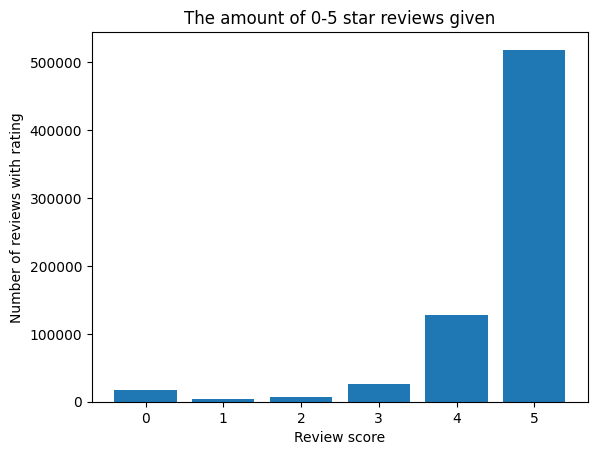

In [11]:
import statistics
import matplotlib.pyplot as plt

print("Total number of recipes:",
        recipes.count()        
)
print("Total number of recipes with at least 1 review:",
      reviews_recipe_i_to_count.count()
)
print()
# Find the most reviewed recipe
most_reviewed = reviews_recipe_i_to_average_score_and_count.takeOrdered(1, lambda kv: -kv[1][1])[0]
recipe_id = recipe_id_and_ingredient_tokens.where(recipe_id_and_ingredient_tokens.i == most_reviewed[0]).select('id').take(1)[0].id
recipe_name = raw_recipes.where(raw_recipes.id == recipe_id).select('name').take(1)[0].name
print("Most reviewed recipe: https://www.food.com/recipe/{}-{}".format(recipe_name.replace(' ', '-'), recipe_id))
print("- average score of {:.2f} with {} reviews (Note: The recipe currently has more reviews)".format(most_reviewed[1][0], most_reviewed[1][1]))
print()



# Average score & count
average_review_score = reviews_recipe_i_to_average_score_and_count.map(lambda kv: kv[1][0]).mean()
print("The average recipe's review score is: {:.3f}".format(
        average_review_score)
)
average_review_count = reviews_recipe_i_to_count.map(lambda kv: kv[1]).mean()
print("The average recipe's number of reviews: {:.3f}".format(
        average_review_count)
)
# Median count
all_counts = reviews_recipe_i_to_count.map(lambda kv: kv[1]).collect()
print("The median recipe's number of reviews: {:.1f}".format(
        statistics.median(all_counts))
)
del all_counts

print()

# Find the amount of [0, 5] star reviews
print("Number of reviews per star:")
reviews_star_counts = (
    reviews_recipe_i_to_score
      .map(lambda kv: (kv[1], 1))
      .reduceByKey(add)
    .takeOrdered(6)
)

for (star, count) in reviews_star_counts:
  print('-', int(star), 'star:', count)
zero_to_four_star_reviews = sum(map((lambda kv: kv[1]), reviews_star_counts[:5]))
print("  - This means there's", zero_to_four_star_reviews, "0-4 star reviews,"
          " far less than the 5 stars alone")
print()

x_vals, n_reviews_per_star = zip(*reviews_star_counts)

plt.title("The amount of 0-5 star reviews given")
plt.xlabel("Review score")
plt.ylabel("Number of reviews with rating")
plt.bar(x_vals, n_reviews_per_star)

#### 2.1.1. Deside our minimum review count cutoff
Recipes have an average of 4.3 reviews, however only a median of 2 reviews.

There seems to be a pattern where most reviewers give a 5 star rating for any recipe they consider simply 'good', even though a more accurate score would be 3-4 stars.

Now, let us consider a cut-off, where we ignore recipes with less than a certain number of reviews.

Total number of recipes with at least 5 reviews: 34348

The average recipe's review score (num reviews >= 5): 4.611
Number of reviews per star (on recipes with at least 5 reviews):
- 0 star: 11183
- 1 star: 2062
- 2 star: 4399
- 3 star: 15343
- 4 star: 76536
- 5 star: 363803
  - This means there's 109523 0-4 star reviews, (still) far less than the 5 stars alone


<BarContainer object of 6 artists>

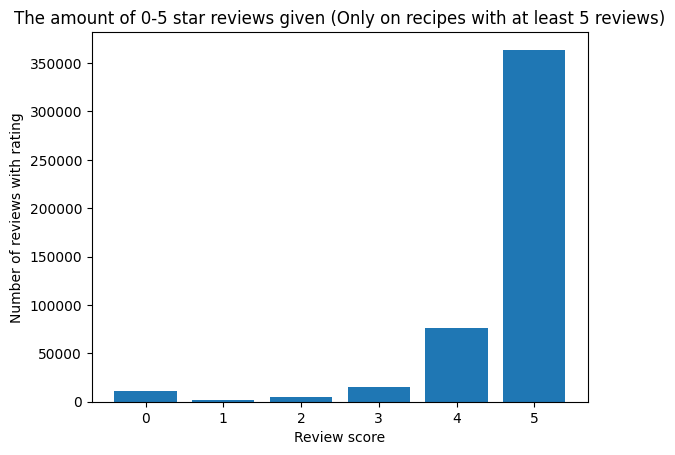

In [12]:
REVIEW_COUNT_CUTOFF = 5

filtered_reviews_with_avg_and_count = (
    reviews_recipe_i_to_average_score_and_count
    .filter(lambda kv: kv[1][1] >= REVIEW_COUNT_CUTOFF)
    .cache()
)

print("Total number of recipes with at least {} reviews: {}".format(
      REVIEW_COUNT_CUTOFF, filtered_reviews_with_avg_and_count.count())
)
print()



# Average score
average_review_score = filtered_reviews_with_avg_and_count.map(lambda kv: kv[1][0]).mean()
print("The average recipe's review score (num reviews >= {}): {:.3f}".format(
        REVIEW_COUNT_CUTOFF, average_review_score)
)

# Find the amount of [0, 5] star reviews on our filtered recipes
print("Number of reviews per star (on recipes with at least {} reviews):".format(REVIEW_COUNT_CUTOFF))
filtered_reviews_to_score = (
    filtered_reviews_with_avg_and_count
      .join(reviews_recipe_i_to_score)
    .map(lambda kv: (kv[1][1], 1))
    .reduceByKey(add)

)
reviews_star_counts = filtered_reviews_to_score.takeOrdered(6)
for (star, count) in reviews_star_counts:
  print('-', int(star), 'star:', count)
zero_to_four_star_reviews = sum(map((lambda kv: kv[1]), reviews_star_counts[:5]))
print("  - This means there's", zero_to_four_star_reviews, "0-4 star reviews,"
          " (still) far less than the 5 stars alone")

x_vals, n_reviews_per_star = zip(*reviews_star_counts)

plt.title("The amount of 0-5 star reviews given (Only on recipes with at least {} reviews)".format(REVIEW_COUNT_CUTOFF))
plt.xlabel("Review score")
plt.ylabel("Number of reviews with rating")
plt.bar(x_vals, n_reviews_per_star)

As noted earlier, the average score is extremely high. This likely means that the score range for good recipes is tight, while a bad recipe would have a larger range.

After trying different review count cut-off value, I have decided on __at least 5 reviews__. I would believe that recipes with this many reviews should have accurate scores, where multiple people have confirmed a recipe came out good, and where one reviewer messing up doesn't condemn a recipe.

It also has the secondary effect of filtering out most of the website's un-notable recipes, which would most likely be full of repeats.


#### 2.1.2. Deside what's a good/bad score



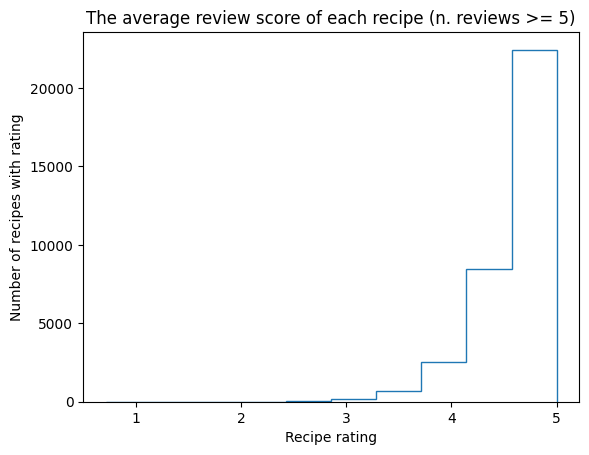

In [13]:
import matplotlib.pyplot as plt
import numpy as np

filtered_scores_avg = (
    filtered_reviews_with_avg_and_count
    .map(lambda kv: kv[1][0])
    .sortBy(lambda x: x)
    .collect()
)

counts, bins = np.histogram(filtered_scores_avg)

plt.title("The average review score of each recipe (n. reviews >= {})".format(REVIEW_COUNT_CUTOFF))
plt.xlabel("Recipe rating")
plt.ylabel("Number of recipes with rating")
plt.stairs(counts, bins)


In [14]:
POOR_AVERAGE_SCORE_THRESHOLD = 3
GOOD_AVERAGE_SCORE_THRESHOLD = 4.2

poor_reviews = filtered_reviews_with_avg_and_count.filter(lambda kv: kv[1][0] <= POOR_AVERAGE_SCORE_THRESHOLD)
good_reviews = filtered_reviews_with_avg_and_count.filter(lambda kv: kv[1][0] >= GOOD_AVERAGE_SCORE_THRESHOLD)

print("Number of reviews with at least {} reviews with an average score below {}: {}".format(
        REVIEW_COUNT_CUTOFF, POOR_AVERAGE_SCORE_THRESHOLD, poor_reviews.count() 
  )
)
print("Number of reviews with at least {} reviews with an average score above {}: {}".format(
        REVIEW_COUNT_CUTOFF, GOOD_AVERAGE_SCORE_THRESHOLD, good_reviews.count() 
  )
)

Number of reviews with at least 5 reviews with an average score below 3: 161
Number of reviews with at least 5 reviews with an average score above 4.2: 30033


As shown above, even an ungenerous 'bad recipe' threshold of 3/5 stars results
in a very small number of reviews. This is partially due to the inflated review
scores given, but also due to the fact we just filtered down this dataset.

Users of this site aren't likely to make a recipe if it already has poor reviews, therefore it is rare for a poorly reviewed recipe to have more than a handful of reviews.

Let's try that again, except this time we ignore the good reviews, and don't
exclude unpopular recipes.

Number of reviews with an average score below 3: 10295


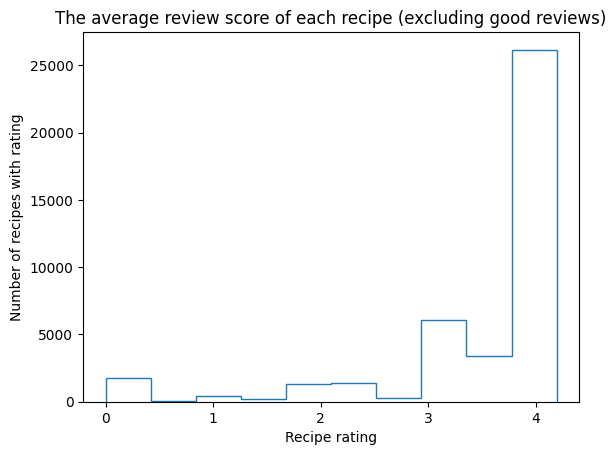

In [15]:
poor_reviews = reviews_recipe_i_to_average_score_and_count.filter(lambda kv: kv[1][0] <= POOR_AVERAGE_SCORE_THRESHOLD)

print("Number of reviews with an average score below {}: {}".format(
        POOR_AVERAGE_SCORE_THRESHOLD, poor_reviews.count() 
  )
)

all_scores_avg = (
    reviews_recipe_i_to_average_score_and_count
    .filter(lambda kv: kv[1][0] < GOOD_AVERAGE_SCORE_THRESHOLD)  # Filter out the good reviews
    .map(lambda kv: kv[1][0])
    .sortBy(lambda x: x)
    .collect()
)

counts, bins = np.histogram(all_scores_avg)

plt.title("The average review score of each recipe (excluding good reviews)")
plt.xlabel("Recipe rating")
plt.ylabel("Number of recipes with rating")
plt.stairs(counts, bins)

Going even further, let's see how many 'bad' recipes even get a second review

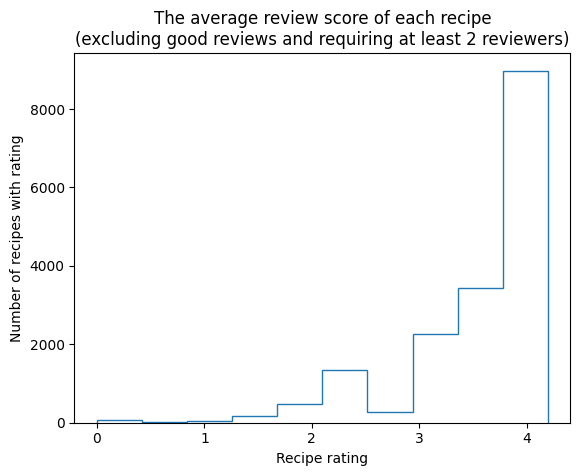

In [16]:
all_scores_avg = (
    reviews_recipe_i_to_average_score_and_count
    .filter(lambda kv: kv[1][0] < GOOD_AVERAGE_SCORE_THRESHOLD)  # Filter out the good reviews
    .filter(lambda kv: kv[1][1] >= 2)  # Checking how many bad recipes even get a second review
    .map(lambda kv: kv[1][0])
    .sortBy(lambda x: x)
    .collect()
)

counts, bins = np.histogram(all_scores_avg)

plt.title("The average review score of each recipe\n(excluding good reviews and requiring at least 2 reviewers)")
plt.xlabel("Recipe rating")
plt.ylabel("Number of recipes with rating")
plt.stairs(counts, bins)

As we can see, most bad recipes aren't even given a second chance.

### 2.1.3. Reassessment

The veracity of the review data for Food.com is brought into question by these facts:
1. Most reviewers will assign a merely 'good' recipe the maximum score of 5 stars
2. Recipes with low scores will be ignored by the vast majority of users

We *should* ignore recipes without many reviews, as we can't conclude a recipe's quality from a small number of opinions.<br>
**However**, we won't be able to find any bad recipes this way, as bad recipes will have low interactions.

---

From this data, I have picked the criteria for a good or bad recipe:
- **Good**: At least **5** reviews with an average rating of **4.2 stars**
- **Bad**: Any number of reviews with an average rating of below **3 stars**
- **Average**: Any number of reviews with an average rating between good and bad

The good reviews should hopefully include reviews with enough ratings to assume they are good with some confidence.<br>
The bad reviews unfortunately can not be assumed with confidence, however they must be included, otherwise we have too few to work with.<br>
The average reviews will include any recipes with a score in-between these. It also purposefully excludes highly scored yet low review count recipes, as we can't confidently say they're average. 

In [17]:
GOOD_REVIEW_COUNT_THRESHOLD = 5
POOR_AVERAGE_SCORE_THRESHOLD = 3
GOOD_AVERAGE_SCORE_THRESHOLD = 4.2

## 3. The code proper

### 3.1. Categorise recipes

In [18]:
# Step 0. Make everything the proper type.
# Currently, each recipe is in the form: Row(id='424415', i='23', ingredient_ids='[389, 7655, 6270, 1527, 3406]')
# i.e. every field is a string, we need fix that.

def recipes_with_parsed_numbers(row: pyspark.Row) -> pyspark.Row:
  i = int(row.i)
  recipe_id = int(row.id)
  ingredient_ids = parse_string_to_list(row.ingredient_ids)
  return pyspark.Row(i=i, id=recipe_id, ingredient_ids=ingredient_ids)


recipe_id_and_ingredient_tokens_parsed = (
    recipe_id_and_ingredient_tokens
    .rdd
    .map(recipes_with_parsed_numbers)
)

# Step 1. Assign the review scores to each review
recipes_and_reviews = (
    recipe_id_and_ingredient_tokens_parsed
    .map(lambda row: (row.i, row))  # To allow a join
    .join(reviews_recipe_i_to_average_score_and_count)  # (i, (row, (avg_review, review_count)))
    .map(lambda kv: pyspark.Row(
        **kv[1][0].asDict(), avg_review=kv[1][1][0], review_count=kv[1][1][1])  # Flatten out
    )
) # Structure: Row(i=int, id=int, ingredient_ids=tuple[int], avg_review=float, review_count=int)


In [19]:
# Step 2. Categorise each recipes
import enum
class RecipeRating(enum.Enum):
  GOOD=0
  AVERAGE=1
  POOR=2
  IGNORE=3

  @staticmethod
  def categorise_row(row: pyspark.Row) -> 'RecipeRating':
    avg = row.avg_review
    count = row.review_count
    if avg <= POOR_AVERAGE_SCORE_THRESHOLD:
      return RecipeRating.POOR
    elif avg >= GOOD_AVERAGE_SCORE_THRESHOLD and count > GOOD_REVIEW_COUNT_THRESHOLD:
      return RecipeRating.GOOD
    elif POOR_AVERAGE_SCORE_THRESHOLD < avg < GOOD_AVERAGE_SCORE_THRESHOLD:
      return RecipeRating.AVERAGE
    else:
      return RecipeRating.IGNORE

categorised_recipes = (
    recipes_and_reviews
    .map(lambda row: pyspark.Row(**row.asDict(), review_category=RecipeRating.categorise_row(row)))
    .filter(lambda row: row.review_category != RecipeRating.IGNORE)
)
print(categorised_recipes.take(1)[0])

Row(i=120056, id=312329, ingredient_ids=(1257, 7655, 6270, 590, 5024, 1119, 4883, 6696, 7946, 5648, 7239, 7705, 7594, 1168, 2683), avg_review=4.0, review_count=1, review_category=<RecipeRating.AVERAGE: 1>)


### 3.2. Apply TF-IDF

In [23]:
# To get the TF-IDF started, we need to get the occurance of ingredients for good/bad recipes (TF)
# and across all recipes (IDF)
all_ingredients_count = (
    categorised_recipes
      .flatMap(lambda row: ((ing_id, 1) for ing_id in row.ingredient_ids))
      .reduceByKey(add)
)
good_ingredients_count = (
    categorised_recipes
      .filter(lambda row: row.review_category == RecipeRating.GOOD)
      .flatMap(lambda row: ((ing_id, 1) for ing_id in row.ingredient_ids))
      .reduceByKey(add)
)
avg_ingredients_count = (
    categorised_recipes
      .filter(lambda row: row.review_category == RecipeRating.AVERAGE)
      .flatMap(lambda row: ((ing_id, 1) for ing_id in row.ingredient_ids))
      .reduceByKey(add)
)
bad_ingredients_count = (
    categorised_recipes
      .filter(lambda row: row.review_category == RecipeRating.POOR)
      .flatMap(lambda row: ((ing_id, 1) for ing_id in row.ingredient_ids))
      .reduceByKey(add)
)


In [25]:
def tf(recipe_count: pyspark.RDD) -> pyspark.RDD:
    most_common_ingredient_count = recipe_count.max(key=lambda kv: kv[1])[1]
    return recipe_count.map(lambda kv: (kv[0], kv[1]/most_common_ingredient_count))

good_ingredient_tf = tf(good_ingredients_count)
avg_ingredient_tf = tf(avg_ingredients_count)
bad_ingredient_tf = tf(bad_ingredients_count)

In [34]:
import math

def idf(count_rdds: list):
  n_docs = len(count_rdds)
  all_rdds = []
  for (i, rdd) in enumerate(count_rdds):
    # We don't need the "overall total" for an IDF
    all_rdds.append(rdd.map(lambda kv: (kv[0], 1)))
  combined_rdd = sc.union(all_rdds)
  document_frequency = combined_rdd.reduceByKey(add)
  word_to_idf_value = document_frequency.map(lambda kv: (kv[0], math.log2(n_docs / kv[1])))

  return word_to_idf_value

inverse_doc_freq = idf([good_ingredients_count, avg_ingredients_count, bad_ingredients_count])

In [40]:
def tfidfi(tfi: pyspark.RDD, idfi: pyspark.rdd):
  ingredient_id_to_tf_and_idf = tfi.join(idfi)
  # TF-IDF = TF * IDF
  return ingredient_id_to_tf_and_idf.map(lambda kv: (kv[0], (kv[1][0] * kv[1][1])))

good_ingredient_tf_idfi = tfidfi(good_ingredient_tf, inverse_doc_freq)
bad_ingredient_tf_idfi = tfidfi(bad_ingredient_tf, inverse_doc_freq)

In [41]:
HOW_MANY_ING_TO_CHECK = 20

most_unique_good_ingredients_ids = (
  good_ingredient_tf_idfi.takeOrdered(HOW_MANY_ING_TO_CHECK, lambda kv: -kv[1])
)
most_unique_bad_ingredients_ids = (
  bad_ingredient_tf_idfi.takeOrdered(HOW_MANY_ING_TO_CHECK, lambda kv: -kv[1])
)


### 3.3. Check against ingredient list

In [45]:
print("Ingredients most common in good recipes:")
for (ing_id, tfidf_value) in most_unique_good_ingredients_ids:
    ingredient = (
        ingredient_map
        .where(ingredient_map.id == ing_id)
        .select('replaced')
        .take(1)[0]
        .replaced
    )
    print("Ingredient: {} with a TF-IDF value of: {:.6f}".format(repr(ingredient), tfidf_value))

print("\n===\n")

print("Ingredients most common in bad recipes:")
for (ing_id, tfidf_value) in most_unique_bad_ingredients_ids:
    ingredient = (
        ingredient_map
        .where(ingredient_map.id == ing_id)
        .select('replaced')
        .take(1)[0]
        .replaced
    )
    print("Ingredient: {} with a TF-IDF value of: {:.6f}".format(repr(ingredient), tfidf_value))

Ingredients most common in good recipes:
Ingredient: 'steak seasoning' with a TF-IDF value of: 0.001039
Ingredient: 'cointreau liqueur' with a TF-IDF value of: 0.000855
Ingredient: 'unpopped popcorn' with a TF-IDF value of: 0.000828
Ingredient: 'center cut pork chop' with a TF-IDF value of: 0.000672
Ingredient: 'hard-cooked egg' with a TF-IDF value of: 0.000672
Ingredient: 'paneer cheese' with a TF-IDF value of: 0.000662
Ingredient: 'medium sherry' with a TF-IDF value of: 0.000662
Ingredient: 'danish blue cheese' with a TF-IDF value of: 0.000662
Ingredient: 'german mustard' with a TF-IDF value of: 0.000662
Ingredient: 'orange sweet potato' with a TF-IDF value of: 0.000662
Ingredient: 'chunk chicken' with a TF-IDF value of: 0.000662
Ingredient: 'mizithra cheese' with a TF-IDF value of: 0.000662
Ingredient: 'small potato' with a TF-IDF value of: 0.000611
Ingredient: 'candy cane' with a TF-IDF value of: 0.000611
Ingredient: 'pastry for a double-crust pie' with a TF-IDF value of: 0.000611
